In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [57]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']


# grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

y_wcvi_slice = np.array(np.arange(250,350))
x_wcvi_slice = np.array(np.arange(550,650))

In [3]:
def tem_sal_timeseries_at_WCVI_locations(grid_scalar):#, j, i):
    
#     temp = grid_scalar.variables['votemper'][0,:, j, i]
#     sal = grid_scalar.variables['vosaline'][0,:, j, i]
    temp = grid_scalar.variables['votemper'][0,:, :, :]
    sal = grid_scalar.variables['vosaline'][0,:, :, :]
    
    scalar_ts = namedtuple('scalar_ts', 'temp, sal')

    return scalar_ts(temp, sal)

In [4]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict
# from datetime import (
#     datetime,
#     timedelta,
# )
# from resource import getrlimit, RLIMIT_NOFILE
import os

# import arrow
# import netCDF4 as nc
# import pandas as pd
# import numpy as np

# import warnings

# from salishsea_tools import hg_commands as hg

# temp_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
# sal_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))

temp_july = np.empty((31,50,Z.shape[0],Z.shape[1]))
sal_july = np.empty((31,50,Z.shape[0],Z.shape[1]))

i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_T.nc')):
#     if fnmatch.fnmatch(file, '*_orig.nc') == False:
#         if fnmatch.fnmatch(file, '*ops_y2015m12d15.nc') == False:
        
#     if file != 'results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d03_orig.nc':
#     scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file), y_wcvi_slice,x_wcvi_slice)
    scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
#             uwind_es = np.append(uwind_es , wind_ts_es[0])
    temp_july[i,...] = scalar_ts[0]
    sal_july[i,...] = scalar_ts[1]
    i = i+1
#     else:
#         continue


(100,)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


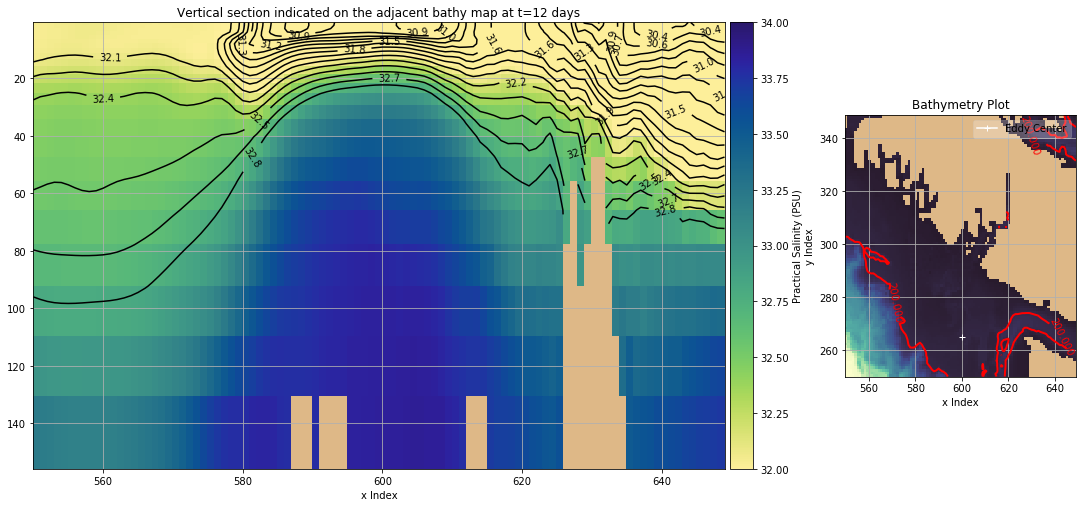

In [66]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 265,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,265,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,265,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


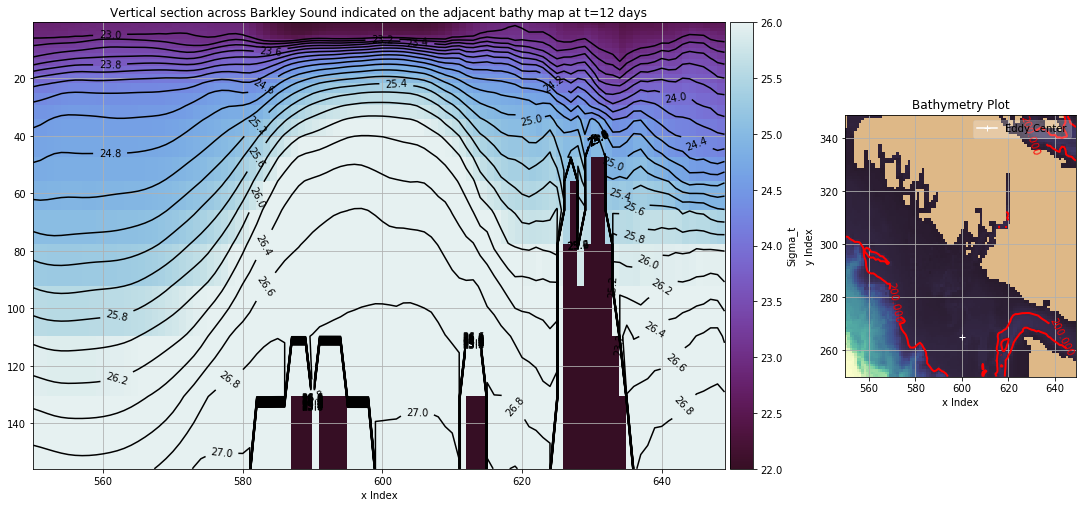

In [74]:
import gsw



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 265,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.dense_r)
cmap.set_bad(land_colour)
temp_0 = temp_july[t, :25, :,:]
temp_tzyx = np.ma.masked_values(temp_0, 0)

Z_loc = zlevels[:25]
lat_loc = lat[y_wcvi_slice,x_wcvi_slice]
lon_loc = lon[y_wcvi_slice,x_wcvi_slice]

pressure_loc = gsw.p_from_z(-Z_loc,np.mean(lat_loc))
rho_loc = np.empty_like(sal_0)
for i in np.arange(25):
    rho_loc[i] = gsw.density.rho(sal_0[i,...], temp_0[i,...], pressure_loc[i]) -1000

    
rho_tzyx = np.ma.masked_values(rho_loc, 0)    
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], rho_tzyx[:25,265,x_wcvi_slice], cmap=cmap, vmin=22, vmax=26)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Sigma_t')
clines = axl.contour(x_wcvi_slice, zlevels[:25], rho_tzyx[:25,265,x_wcvi_slice], np.arange(23, 30, 0.2), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

In [9]:
zlevels[18]

55.76429

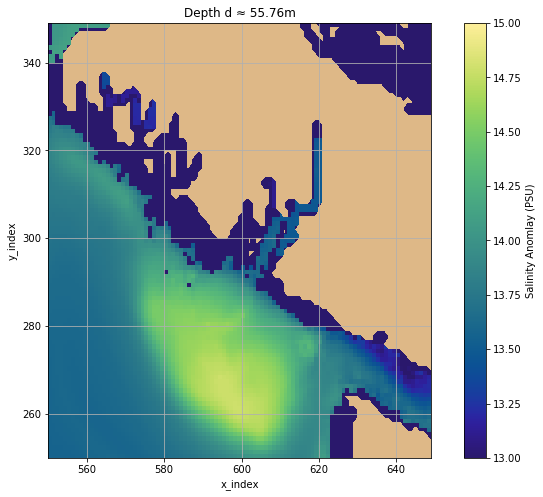

In [76]:
t = 12
level = 18



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 13, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.grid()

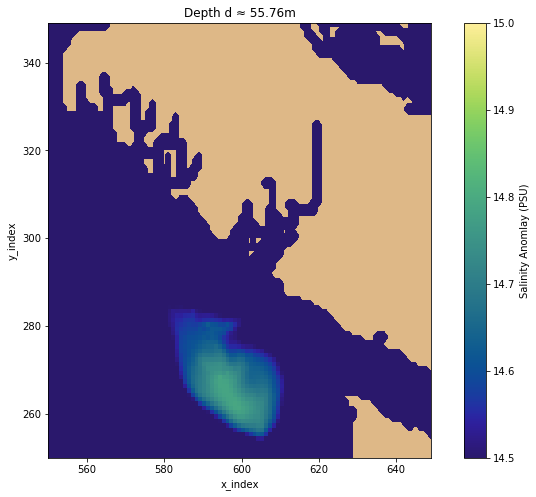

In [23]:
t = 12
level = 18



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 14.5, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

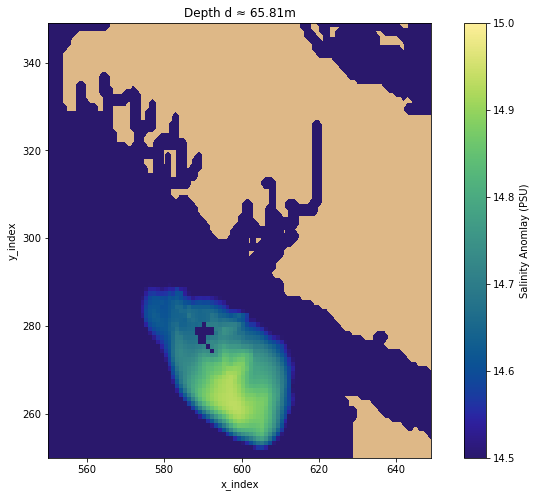

In [27]:
t = 12
level = 19



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 14.5, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

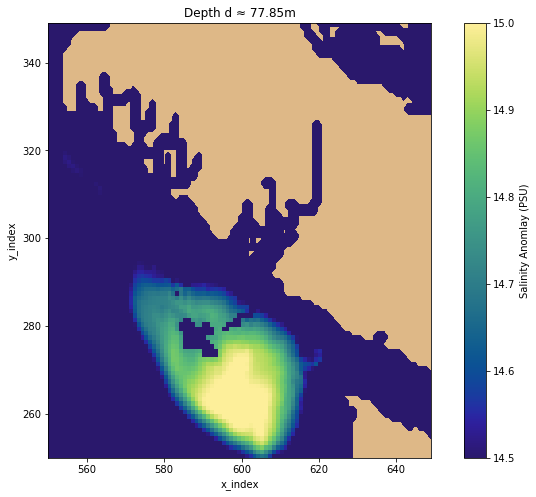

In [28]:
t = 12
level = 20



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 14.5, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

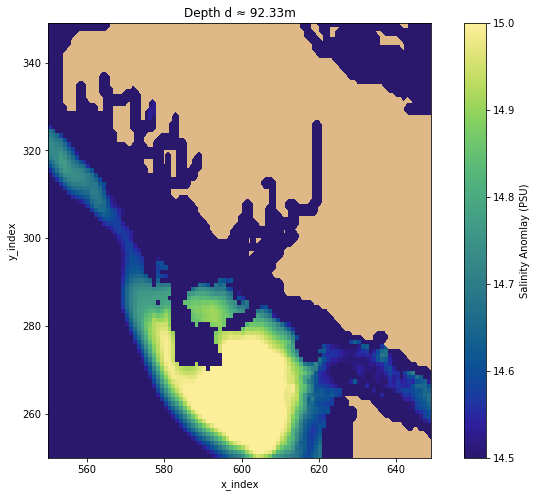

In [29]:
t = 12
level = 21



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 14.5, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

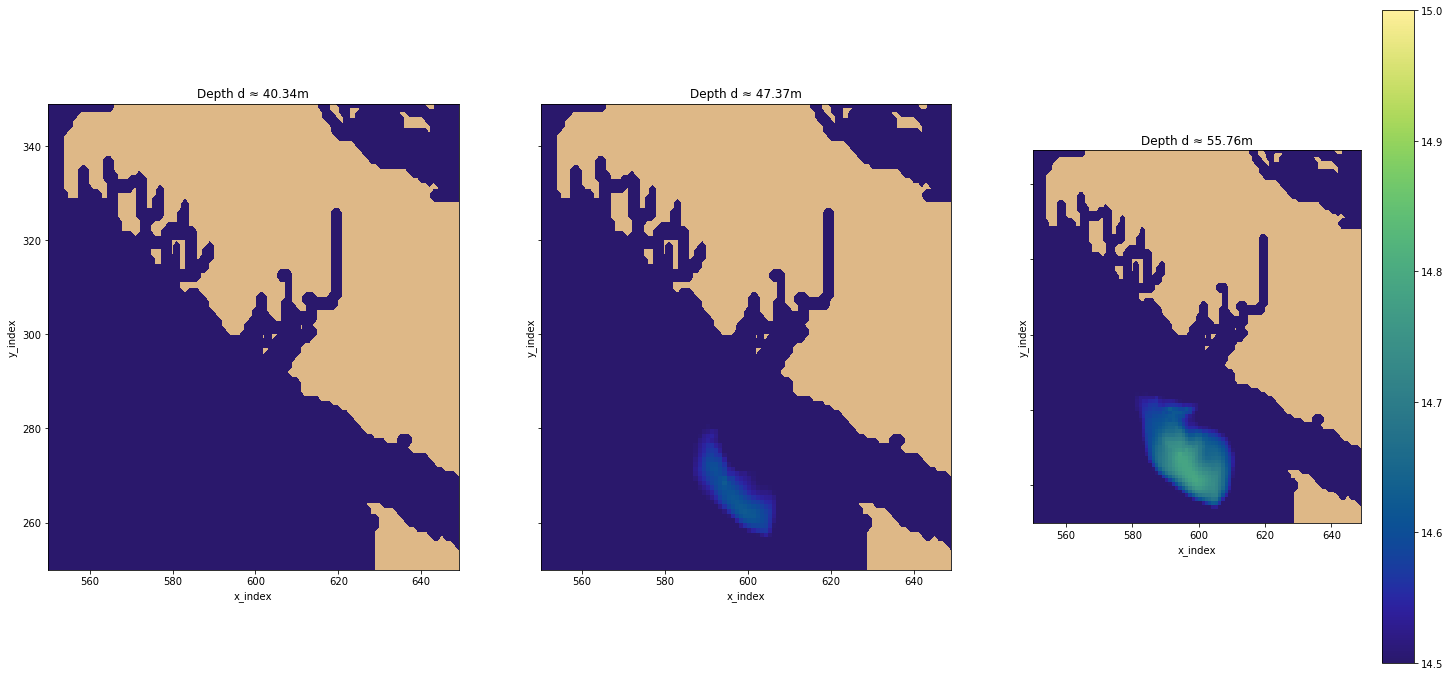

In [37]:
fig, axs = plt.subplots(1, 3,  figsize=(25, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')

t = 12

level = (16, 17, 18)
for ax, d in zip(axs, level):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,d,250:350,550:650]- np.nanmean(sal_july[t,d,...]), cmap=cmap, vmin = 14.5, vmax = 15)
    viz_tools.set_aspect(ax)
    ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[d]))
    viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
#     cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Salinity Anomlay (PSU)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    
cbar = fig.colorbar(mesh, ax=ax)

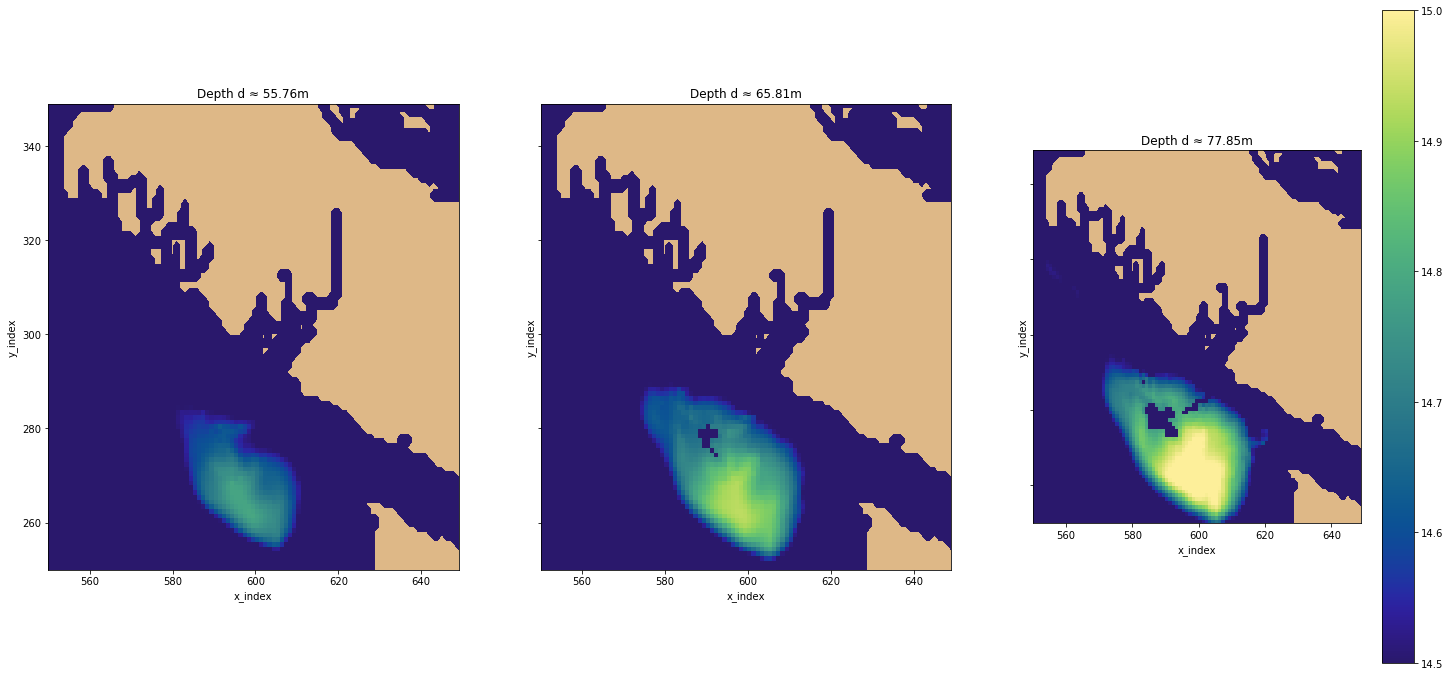

In [38]:
fig, axs = plt.subplots(1, 3,  figsize=(25, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')

t = 12

level = (18, 19, 20)
for ax, d in zip(axs, level):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,d,250:350,550:650]- np.nanmean(sal_july[t,d,...]), cmap=cmap, vmin = 14.5, vmax = 15)
    viz_tools.set_aspect(ax)
    ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[d]))
    viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
#     cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Salinity Anomlay (PSU)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    
cbar = fig.colorbar(mesh, ax=ax)

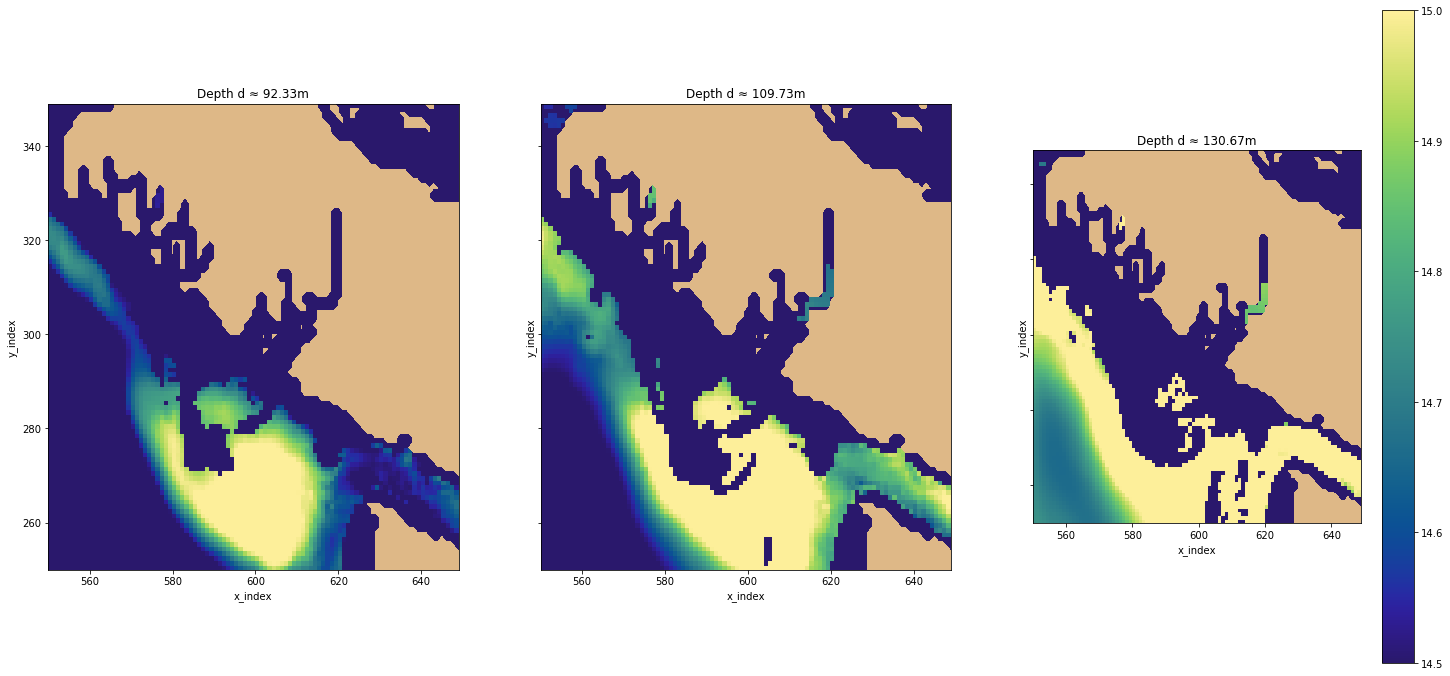

In [39]:
fig, axs = plt.subplots(1, 3,  figsize=(25, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')

t = 12

level = (21, 22, 23)
for ax, d in zip(axs, level):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,d,250:350,550:650]- np.nanmean(sal_july[t,d,...]), cmap=cmap, vmin = 14.5, vmax = 15)
    viz_tools.set_aspect(ax)
    ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[d]))
    viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
#     cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Salinity Anomlay (PSU)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    
cbar = fig.colorbar(mesh, ax=ax)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


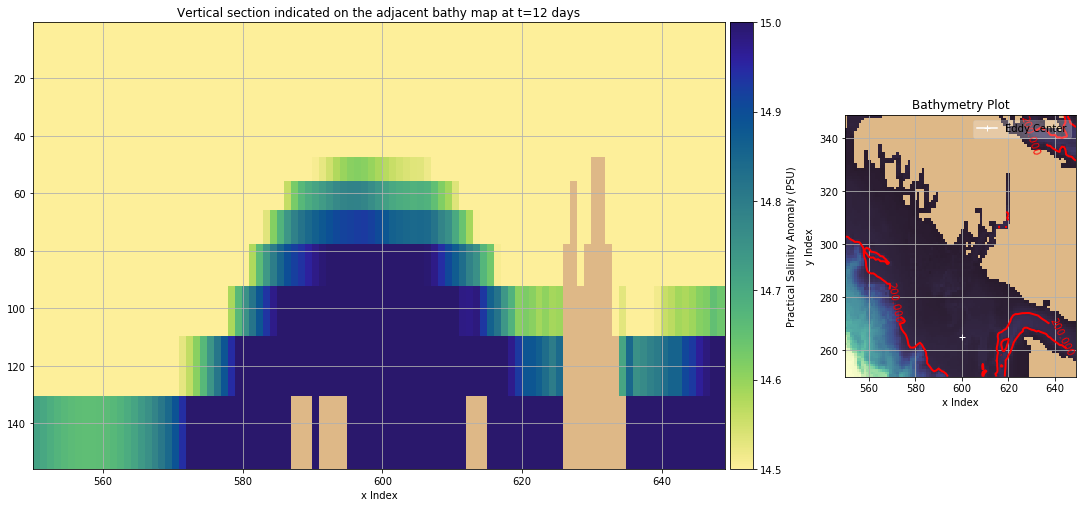

In [90]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))



# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 265,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_ano = np.empty_like(sal_0)
sal_0 = np.ma.masked_values(sal_0, 0)

for i in np.arange(sal_0.shape[0]):
    sal_ano[i,...] = sal_0[i,...] - np.mean(sal_july[t,i,...])

sal_tzyx = np.ma.masked_values(sal_ano, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,265,x_wcvi_slice], cmap=cmap, vmin=14.5, vmax=15)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity Anomaly (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,265,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

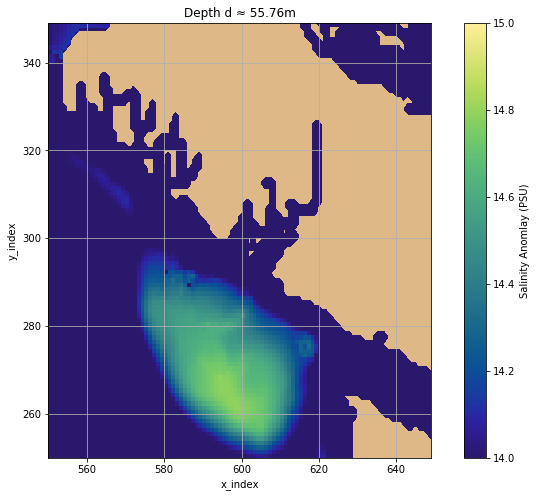

In [95]:
t = 12
level = 18



fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,level,250:350,550:650]- np.nanmean(sal_july[t,level,...]), cmap=cmap, vmin = 14, vmax = 15)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("Depth d \u2248 {d:.2f}m".format(d=zlevels[level]))
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.grid()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


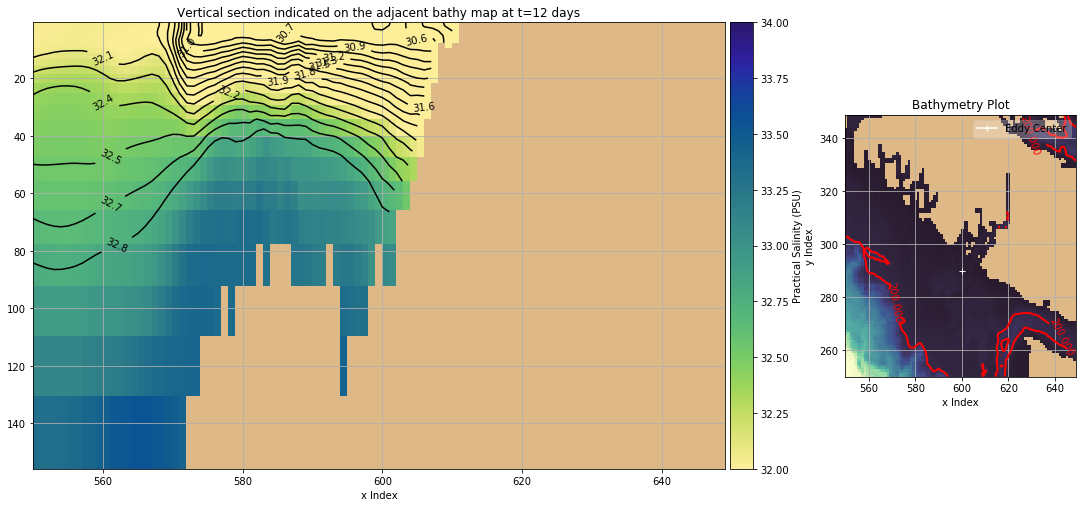

In [92]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


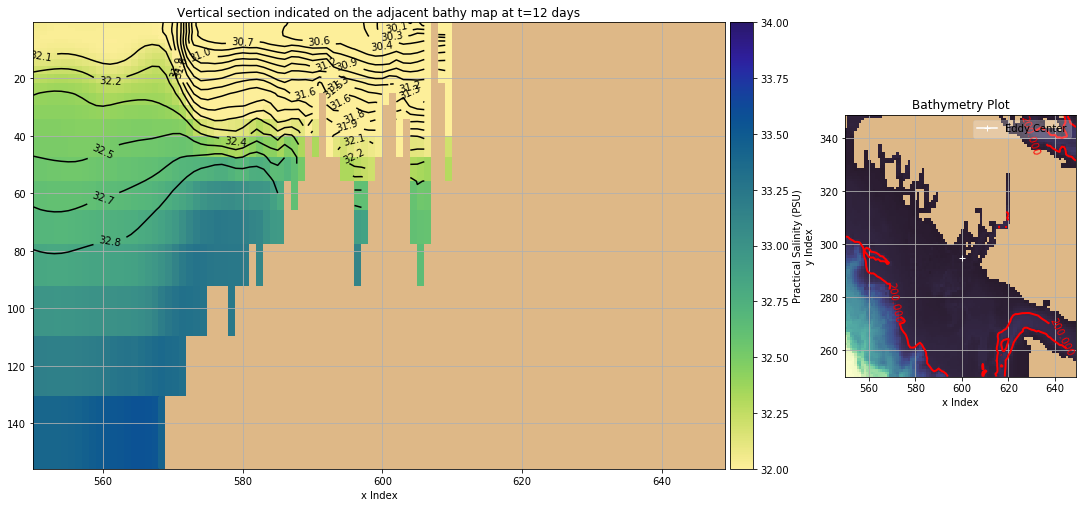

In [96]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 295,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,295,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,295,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


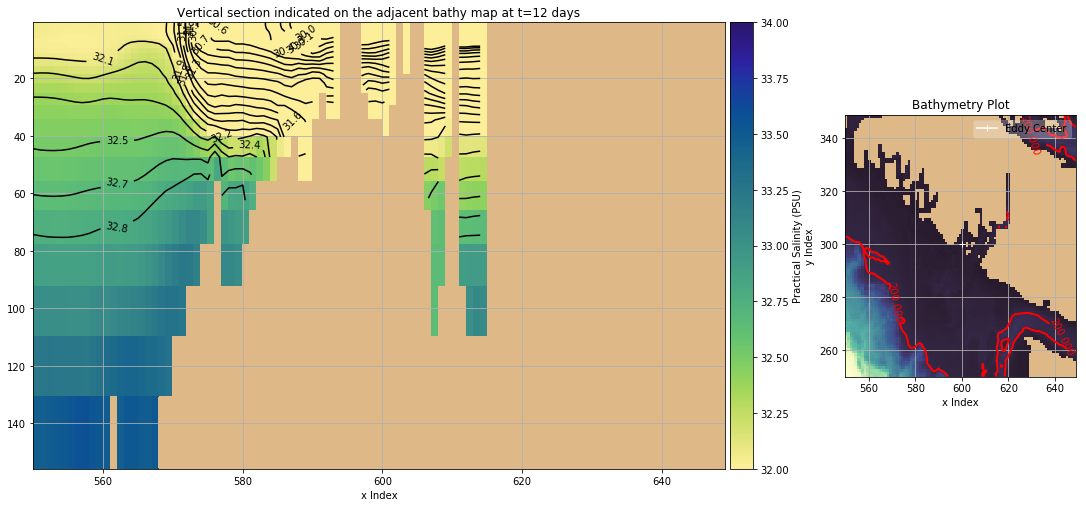

In [97]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 300,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,300,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,300,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


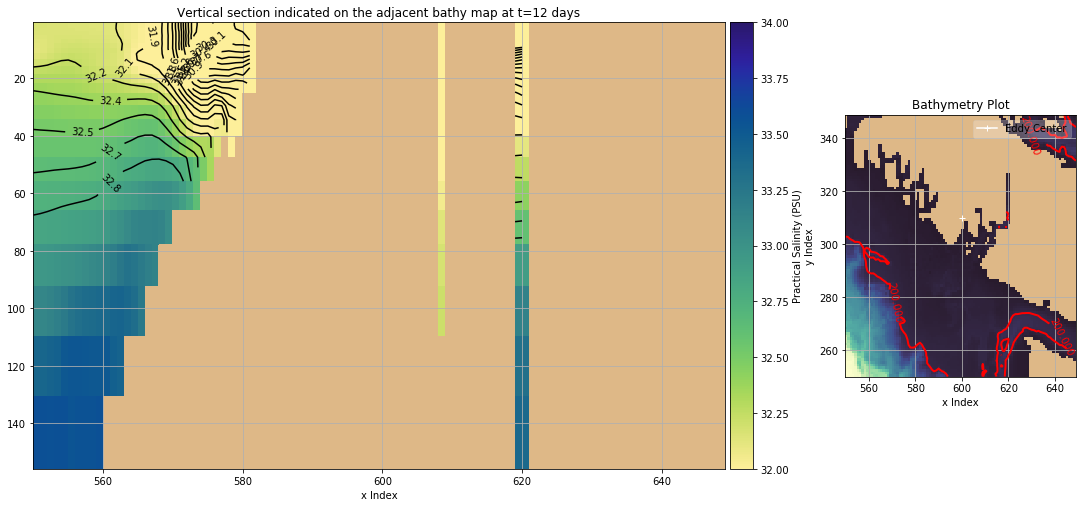

In [98]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 310,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,310,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,310,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


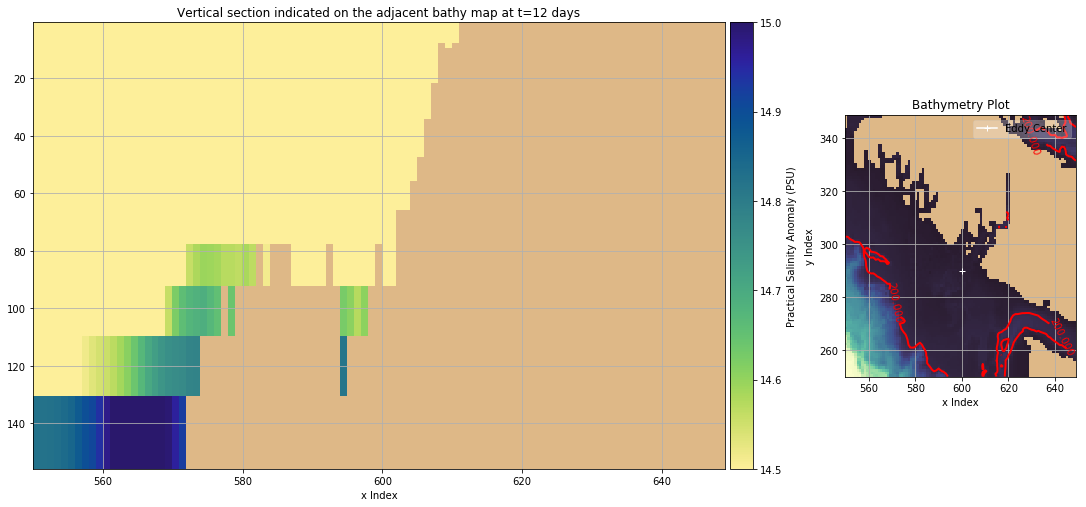

In [101]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))



# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_ano = np.empty_like(sal_0)
sal_0 = np.ma.masked_values(sal_0, 0)

for i in np.arange(sal_0.shape[0]):
    sal_ano[i,...] = sal_0[i,...] - np.mean(sal_july[t,i,...])

sal_tzyx = np.ma.masked_values(sal_ano, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,290,x_wcvi_slice], cmap=cmap, vmin=14.5, vmax=15)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity Anomaly (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


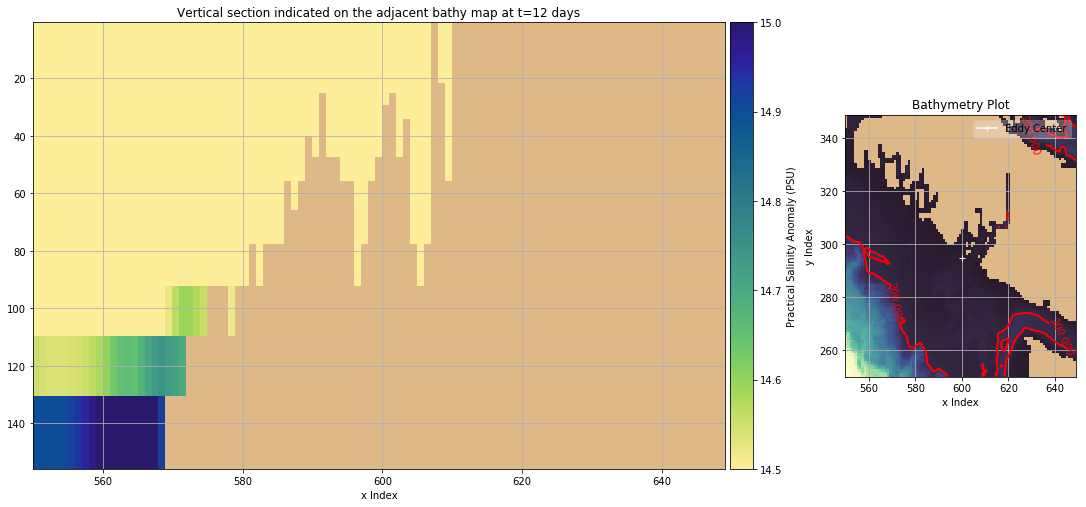

In [102]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))



# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], cmap=cmap, vmin=0)
axr.plot(
    600, 295,
    linestyle='-', marker='+', color='white',
    label='Eddy Center',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[250:350,550:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :25, :,:]
sal_ano = np.empty_like(sal_0)
sal_0 = np.ma.masked_values(sal_0, 0)

for i in np.arange(sal_0.shape[0]):
    sal_ano[i,...] = sal_0[i,...] - np.mean(sal_july[t,i,...])

sal_tzyx = np.ma.masked_values(sal_ano, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:25])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,295,x_wcvi_slice], cmap=cmap, vmin=14.5, vmax=15)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity Anomaly (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:25], sal_tzyx[:25,295,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section indicated on the adjacent bathy map at t={0} days'.format(t))